In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import numpy as np

# Load the dataset
df = pd.read_csv("CTDAPD Dataset.csv")

# Handle missing values by filling them with the mode (most frequent value)
def preprocess_data(dataframe):
    dataframe = dataframe.fillna(dataframe.mode().iloc[0])  # Fill missing values with mode
    # Add time-based features (DayOfWeek, Hour, Month) if 'Date' column exists
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe['Hour'] = dataframe['Date'].dt.hour
        dataframe['DayOfWeek'] = dataframe['Date'].dt.dayofweek
        dataframe['Month'] = dataframe['Date'].dt.month
        # Drop 'Date' after extracting features
        dataframe = dataframe.drop(columns=['Date'])
    return dataframe

# Feature Engineering: Assigning threat severity
def get_severity(row):
    # No threat
    if row['Label'] == 0:
        return 0  # No threat
    
    # Critical threat (Severity = 4)
    if row['IDS_Alert_Count'] > 10 and row['Anomaly_Score'] > 80 and row['Attack_Severity'] == 'Critical':
        return 4  # Critical threat
    
    # High-level threat (Severity = 3)
    if row['IDS_Alert_Count'] > 7 and row['Anomaly_Score'] > 70:
        return 3  # High-level threat
    
    # Medium-level threat (Severity = 2)
    if row['Anomaly_Score'] > 50 or row['IDS_Alert_Count'] > 5:
        return 2  # Medium-level threat
    
    # Low-level threat (Severity = 1)
    return 1  # Low-level threat

df['Threat_Severity'] = df.apply(get_severity, axis=1)

# Encoding categorical variables using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['Protocol_Type', 'Attack_Vector', 'Attack_Severity', 'Botnet_Family', 'Malware_Type', 'System_Patch_Status']

# Encode categorical columns
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Check for non-numeric columns that need to be removed (like IPs)
for col in df.select_dtypes(include=[object]).columns:
    if df[col].str.contains(r'\d+\.\d+\.\d+\.\d+', regex=True).any():
        df = df.drop(columns=[col])  # Drop IP columns

# Features (X) and target variable (y)
X = df.drop(['Label', 'Threat_Severity','Date'], axis=1)  # Drop 'Threat_Severity' and 'Label' columns
y = df['Threat_Severity']  # This is the target variable

# Clip numeric values only to handle extreme values
X_numeric = X.select_dtypes(include=[np.number])  # Select only numeric columns
X_numeric = np.clip(X_numeric, -1e10, 1e10)  # Clip numeric columns

# Replace the original numeric columns in X with clipped values
X[X_numeric.columns] = X_numeric
from imblearn.over_sampling import SMOTE

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Now split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Splitting the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_reg = classification_report(y_test, y_pred)

print("Model Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_reg)

# Save the model, scaler, and label encoder
joblib.dump(model, 'logistic_regression_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')

# Save the processed data (excluding 'Threat_Severity' and 'Label')
df_processed = df.drop(['Threat_Severity', 'Label'], axis=1)  # Ensure no target columns are included
df_processed.to_csv('processed_data.csv', index=False)

print("Model, scaler, and label encoder have been saved.")
df.info()


Model Accuracy:  0.9907824662023761
Confusion Matrix:
 [[9691  152]
 [  28 9657]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.98      0.99      9843
           2       0.98      1.00      0.99      9685

    accuracy                           0.99     19528
   macro avg       0.99      0.99      0.99     19528
weighted avg       0.99      0.99      0.99     19528

Model, scaler, and label encoder have been saved.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54768 entries, 0 to 54767
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         54768 non-null  object 
 1   Source_Port                  54768 non-null  int64  
 2   Destination_Port             54768 non-null  int64  
 3   Protocol_Type                54768 non-null  int32  
 4   Flow_Duration                54768 non-null  int64  
 5

Class distribution before SMOTE:
Threat_Severity
1    48818
2     5950
Name: count, dtype: int64

Class distribution after SMOTE:
Threat_Severity
1    48818
2    48818
Name: count, dtype: int64


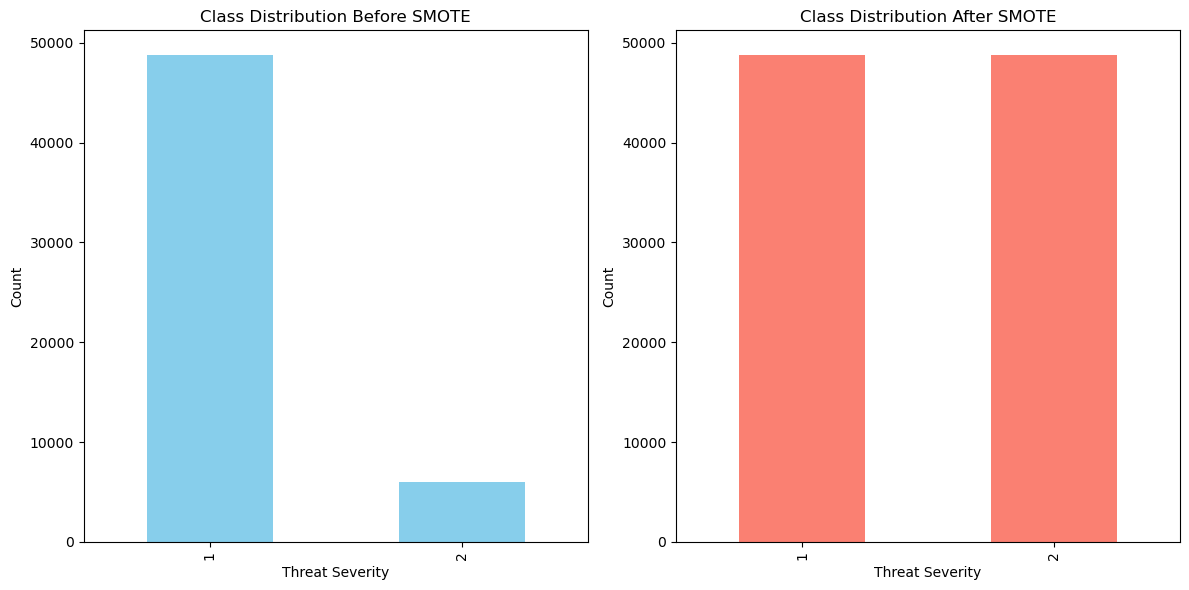

In [19]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Threat_Severity' is your target variable
# Check the distribution of threat severity classes before SMOTE
print("Class distribution before SMOTE:")
print(df['Threat_Severity'].value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check the distribution of threat severity classes after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Optional: Visualize the class distribution before and after SMOTE
plt.figure(figsize=(12, 6))

# Before SMOTE
plt.subplot(1, 2, 1)
df['Threat_Severity'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Threat Severity')
plt.ylabel('Count')

# After SMOTE
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', color='salmon')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Threat Severity')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.datasets import make_classification

# Generate synthetic data for high-level and critical threats
X_synthetic, y_synthetic = make_classification(n_samples=1000, n_features=X.shape[1], 
                                               n_classes=2, n_clusters_per_class=1, 
                                               weights=[0.5, 0.5], random_state=42)

# Map synthetic classes to high-level (3) and critical (4) threats
y_synthetic = np.where(y_synthetic == 0, 3, 4)  # Map 0 to 3 (high-level), 1 to 4 (critical)

# Combine with existing data
X_combined = np.vstack((X_scaled, X_synthetic))
y_combined = np.concatenate((y, y_synthetic))
print("\nClass distribution after combining with synthetic data:")
print(pd.Series(y_combined).value_counts())

# Generate more synthetic data for high-level and critical threats
X_synthetic_more, y_synthetic_more = make_classification(n_samples=5000, n_features=X.shape[1], 
                                                         n_classes=2, n_clusters_per_class=1, 
                                                         weights=[0.5, 0.5], random_state=42)

# Map synthetic classes to high-level (3) and critical (4) threats
y_synthetic_more = np.where(y_synthetic_more == 0, 3, 4)  # Map 0 to 3 (high-level), 1 to 4 (critical)

# Combine with existing data
X_combined = np.vstack((X_combined, X_synthetic_more))
y_combined = np.concatenate((y_combined, y_synthetic_more))

print("\nClass distribution after combining with synthetic data:")
print(pd.Series(y_combined).value_counts())



Class distribution after combining with synthetic data:
1    48818
2     5950
4      501
3      499
Name: count, dtype: int64

Class distribution after combining with synthetic data:
1    48818
2     5950
4     3007
3     2993
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Model Accuracy: ", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", classification_report_rf)

# Save the Random Forest model
#joblib.dump(rf_model, 'random_forest_model.joblib')

Random Forest Model Accuracy:  0.9997951659156084
Confusion Matrix:
 [[9843    0]
 [   4 9681]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9843
           2       1.00      1.00      1.00      9685

    accuracy                           1.00     19528
   macro avg       1.00      1.00      1.00     19528
weighted avg       1.00      1.00      1.00     19528

